## Imports

In [58]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import numpy as np
import os, sys
import torch

from torch.utils.data import TensorDataset, random_split
import torch.nn as nn
from sklearn.metrics import confusion_matrix


In [59]:
sys.path.append("/Users/naliniramanathan/projects/snn_project/randman")
import randman
from randman import Randman

## Universal Model Settings

We set them up here since some of the random manifold components are dependent on this so it has the right structure

In [60]:
# Settings
nb_inputs  = 100
nb_hidden  = 4
nb_outputs = 2

time_step = 1e-3
nb_steps  = 200

batch_size = 256

In [61]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

dtype = torch.float

## Create the Random Manifolds

In [62]:
def standardize(x,eps=1e-7):
    mi,_ = x.min(0)
    ma,_ = x.max(0)
    return (x-mi)/(ma-mi+eps)

def make_spiking_dataset(nb_classes=10, nb_units=100, nb_steps=100, step_frac=1.0, dim_manifold=2, nb_spikes=1, nb_samples=1000, alpha=2.0, shuffle=True, classification=True, seed=None):
    """ Generates event-based generalized spiking randman classification/regression dataset. 
    In this dataset each unit fires a fixed number of spikes. So ratebased or spike count based decoding won't work. 
    All the information is stored in the relative timing between spikes.
    For regression datasets the intrinsic manifold coordinates are returned for each target.
    Args: 
        nb_classes: The number of classes to generate
        nb_units: The number of units to assume
        nb_steps: The number of time steps to assume
        step_frac: Fraction of time steps from beginning of each to contain spikes (default 1.0)
        nb_spikes: The number of spikes per unit
        nb_samples: Number of samples from each manifold per class
        alpha: Randman smoothness parameter
        shuffe: Whether to shuffle the dataset
        classification: Whether to generate a classification (default) or regression dataset
        seed: The random seed (default: None)
    Returns: 
        A tuple of data,labels. The data is structured as numpy array 
        (sample x event x 2 ) where the last dimension contains 
        the relative [0,1] (time,unit) coordinates and labels.
    """
  
    data = []
    labels = []
    targets = []

    if seed is not None:
        np.random.seed(seed)
    
    max_value = np.iinfo(np.int64).max
    randman_seeds = np.random.randint(max_value, size=(nb_classes,nb_spikes) )

    for k in range(nb_classes):
        x = np.random.rand(nb_samples,dim_manifold)
        submans = [ randman.Randman(nb_units, dim_manifold, alpha=alpha, seed=randman_seeds[k,i]) for i in range(nb_spikes) ]
        units = []
        times = []
        for i,rm in enumerate(submans):
            y = rm.eval_manifold(x)
            y = standardize(y)
            units.append(np.repeat(np.arange(nb_units).reshape(1,-1),nb_samples,axis=0))
            times.append(y.numpy())

        units = np.concatenate(units,axis=1)
        times = np.concatenate(times,axis=1)
        events = np.stack([times,units],axis=2)
        data.append(events)
        labels.append(k*np.ones(len(units)))
        targets.append(x)

    data = np.concatenate(data, axis=0)
    labels = np.array(np.concatenate(labels, axis=0), dtype=np.int64)
    targets = np.concatenate(targets, axis=0)

    if shuffle:
        idx = np.arange(len(data))
        np.random.shuffle(idx)
        data = data[idx]
        labels = labels[idx]
        targets = targets[idx]

    data[:,:,0] *= nb_steps*step_frac
    # data = np.array(data, dtype=int)

    if classification:
        return data, labels
    else:
        return data, targets

In [63]:
data,labels = make_spiking_dataset(nb_classes=nb_outputs, nb_units=nb_inputs, nb_steps=nb_steps, dim_manifold=2, seed=42, nb_samples=int(batch_size/nb_outputs)*2)

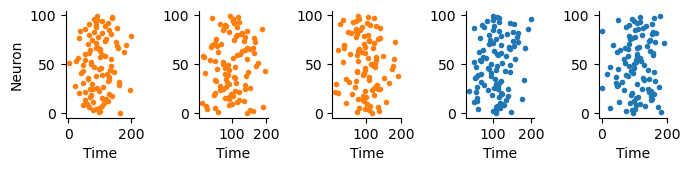

In [64]:
# Show spike raster plots four random example inputs
gs = GridSpec(1,5)
fig = plt.figure(figsize=(7,1.8),dpi=100)

for i in range(5):    
    ax = fig.add_subplot(gs[i])
    ax.scatter(data[i,:,0], data[i,:,1], marker=".", color=sns.color_palette()[labels[i]])
    ax.set_xlabel("Time")
    if i==0: ax.set_ylabel("Neuron")
    
plt.tight_layout()
sns.despine()

### Data Preparation for Model Training

In [65]:
# Convert the spike events to a tensor format suitable for our SNN PyTorch implementation

def convert_to_x_data(spike_events, nb_steps, nb_units):
    # Initialize a tensor of zeros (nb_steps, nb_units)
    x_data = torch.zeros((nb_steps, nb_units), dtype=torch.float32)
    
    # Iterate through each spike event (time, unit)
    for event in spike_events:
        time_step = int(event[0])  # Convert time to an index in the range [0, nb_steps-1]
        unit_id = int(event[1])  # Unit index (neuron)
        x_data[time_step, unit_id] = 1  # Mark the spike at the correct time step and unit
    
    return x_data

def create_x_data(data):
    x_data = []
    for sample in data:
        x_data.append(convert_to_x_data(sample, nb_steps, nb_units=nb_inputs))

    # Convert list of tensors into a single PyTorch tensor (batch of samples)
    x_data = torch.stack(x_data)  # Shape: (num_samples, nb_steps, nb_units)
    return x_data

In [66]:
x_data = create_x_data(data)

In [67]:
# Train vs. test split

data_tensor = torch.tensor(x_data, dtype=torch.float32)  # Shape: (num_samples, num_events, 2)
labels_tensor = torch.tensor(labels, dtype=torch.int64)  # Shape: (num_samples,)

# Combine data and labels into a PyTorch Dataset
dataset = TensorDataset(data_tensor, labels_tensor)

# Define the sizes for train and test subsets
train_ratio = 0.5  # 80% for training, 20% for testing
train_size = int(train_ratio * len(dataset))
test_size = len(dataset) - train_size

# Split the dataset into train and test subsets
train_subset, test_subset = random_split(dataset, [train_size, test_size])

# Convert back to x_data and y_data for train and test subsets
x_data = [data for data, _ in train_subset]
x_data = torch.stack(x_data)
y_data = [label for _, label in train_subset]
y_data = torch.tensor(y_data, dtype=torch.int64)
y_data = y_data.to(device)

x_test = [data for data, _ in test_subset]
x_test = torch.stack(x_test)
y_test = [label for _, label in test_subset]
y_test = torch.tensor(y_test, dtype=torch.int64)
y_test = y_test.to(device)


/var/folders/7b/0zqwym191dq_5jvhhbf5lfgr0000gn/T/ipykernel_68034/3238680790.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_tensor = torch.tensor(x_data, dtype=torch.float32)  # Shape: (num_samples, num_events, 2)


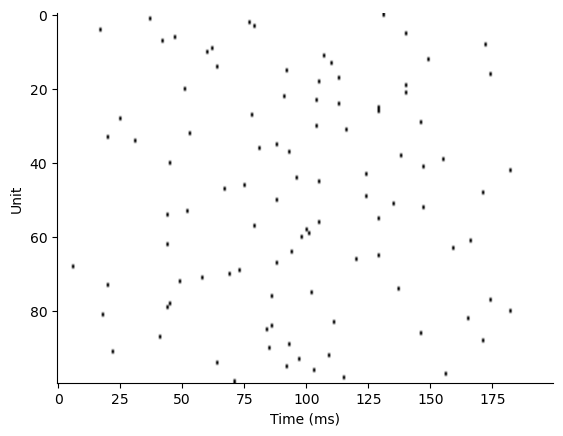

In [68]:
data_id = 2
plt.imshow(x_test[data_id].cpu().t(), cmap=plt.cm.gray_r, aspect="auto")
plt.xlabel("Time (ms)")
plt.ylabel("Unit")
sns.despine()

## Create a Baseline SNN Hybrid Model

### Model Implementation - No Recurrent Weights

The input is a set of spikes. At each timestep, certain SNN neurons fire in response to those inputs. The ANNs act as recurrent units within the network. We'll exclude the recurrent weights to simplify things to start.

#### SNN Code

In [69]:
tau_mem = 10e-3
tau_syn = 5e-3

alpha   = float(np.exp(-time_step/tau_syn))
beta    = float(np.exp(-time_step/tau_mem))

weight_scale = 7*(1.0-beta) # this should give us some spikes to begin with

w1 = torch.empty((nb_inputs, nb_hidden),  device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(w1, mean=0.0, std=weight_scale/np.sqrt(nb_inputs))

w2 = torch.empty((nb_hidden, nb_outputs), device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(w2, mean=0.0, std=weight_scale/np.sqrt(nb_hidden))

w1 = w1.to(device)

print("init done")

init done


In [70]:
def spike_fn(x):
    out = torch.zeros_like(x)
    out[x > 0] = 1.0
    return out

def run_snn(inputs, timesteps=nb_steps):
    inputs = inputs.to(device)
    h1 = torch.einsum("abc,cd->abd", (inputs, w1))
    syn = torch.zeros((batch_size,nb_hidden), device=device, dtype=dtype)
    mem = torch.zeros((batch_size,nb_hidden), device=device, dtype=dtype)

    mem_rec = []
    spk_rec = []

    # Compute hidden layer activity
    for t in range(timesteps):
        mthr = mem-1.0
        out = spike_fn(mthr)
        rst = out.detach() # We do not want to backprop through the reset

        new_syn = alpha*syn +h1[:,t]
        new_mem = (beta*mem +syn)*(1.0-rst)

        mem_rec.append(mem)
        spk_rec.append(out)
        
        mem = new_mem
        syn = new_syn

    mem_rec = torch.stack(mem_rec,dim=1)
    spk_rec = torch.stack(spk_rec,dim=1)

    # Readout layer
    h2= torch.einsum("abc,cd->abd", (spk_rec, w2))
    flt = torch.zeros((batch_size,nb_outputs), device=device, dtype=dtype)
    out = torch.zeros((batch_size,nb_outputs), device=device, dtype=dtype)
    out_rec = [out]
    for t in range(timesteps):
        new_flt = alpha*flt +h2[:,t]
        new_out = beta*out +flt

        flt = new_flt
        out = new_out

        out_rec.append(out)

    out_rec = torch.stack(out_rec,dim=1)
    other_recs = [mem_rec, spk_rec]
    return out_rec, other_recs

In [71]:
def plot_voltage_traces(mem, spk=None, dim=(3,5), spike_height=5):
    gs=GridSpec(*dim)
    if spk is not None:
        dat = 1.0*mem
        dat[spk>0.0] = spike_height
        dat = dat.detach().cpu().numpy()
    else:
        dat = mem.detach().cpu().numpy()
    for i in range(np.prod(dim)):
        if i==0: a0=ax=plt.subplot(gs[i])
        else: ax=plt.subplot(gs[i],sharey=a0)
        ax.plot(dat[i])
        ax.axis("off")

In [72]:
def print_classification_accuracy(timesteps=nb_steps, model = run_snn):
    """ Dirty little helper function to compute classification accuracy. """
    output,_ = model(x_data)
    m,_= torch.max(output,1) # max over time
    _,am=torch.max(m,1) # argmax over output units
    am = am.detach().cpu().numpy() # convert to numpy
    # Compute accuracy
    acc = np.mean((y_data.detach().cpu().numpy()==am))
    print("Accuracy %.3f"%acc)

In [73]:
def count_spikes(spk_rec):
    """ Count the number of spikes in the spiking activity. """
    count = torch.sum(spk_rec, dim=1)
    return count

#### SNN Only

The mem_rec and spike_rec will show the resulting impact of all 256 neurons on the hidden layer.

In [74]:
out_rec,other_recs = run_snn(x_data)

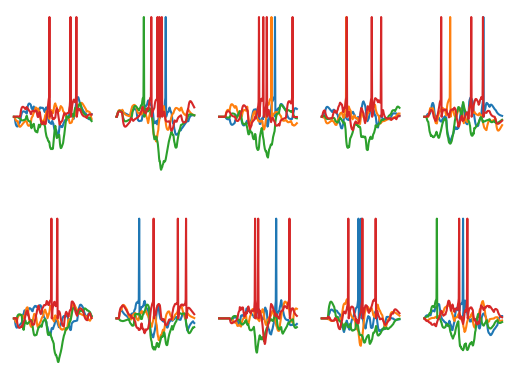

In [75]:
plot_voltage_traces(other_recs[0],other_recs[1],dim=(2,5))

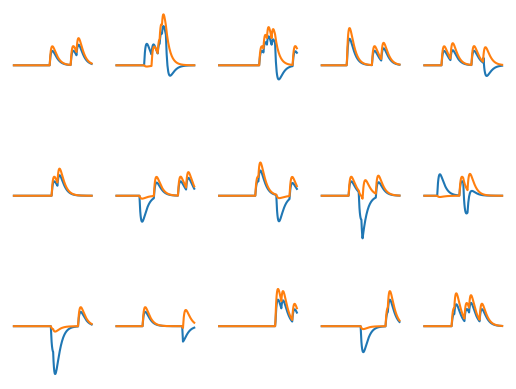

In [76]:
fig=plt.figure(dpi=100)
plot_voltage_traces(out_rec)

In [77]:
print_classification_accuracy()

Accuracy 0.551


#### ANN Only

Let's model an RNN with a similar structure to our SNN. It will take in our temporal data (spikes), and then transform it accordingly in each layer using the weights.

Since we take spikes, weight them, and then output them using traditional ReLU, we don't really need to worry about conversion.

We'd usually have recurrent weights for the RNN, but since we excluded them for the SNN we'll do the same here.


In [78]:
x_data.shape

torch.Size([256, 200, 100])

In [79]:
w1.shape

torch.Size([100, 4])

In [80]:
# The following lines will reinitialize the weights
torch.nn.init.normal_(w1, mean=0.0, std=weight_scale/np.sqrt(nb_inputs))
torch.nn.init.normal_(w2, mean=0.0, std=weight_scale/np.sqrt(nb_hidden))
print("init done")

init done


In [81]:
def run_rnn(inputs, timesteps=nb_steps):
    inputs = inputs.to(device)
    # Weights for the hidden layer for RNN is just w1 -- multiplying by inputs just gives us the output at each timestep
    h1 = torch.einsum("abc,cd->abd", (inputs, w1))
    # We could also add a bias term but let's exclude for now to make the merging more simple

    interim_rec = []

    # The difference for a pure ANN is that the hidden and the output layer usually happen at the same time
    # It's really fine that they're different here though if we just compute them sequentially

    for t in range(timesteps):
        # ADD RECURRENT WEIGHT
        layer_weights = h1[:,t]
    
        # Use a relu function similar to what's done in other models
        out = torch.relu(layer_weights)
        interim_rec.append(out)


    interim_rec = torch.stack(interim_rec,dim=1)

    # Readout layer
    h2= torch.einsum("abc,cd->abd", (interim_rec, w2))
    out = torch.zeros((batch_size,nb_outputs), device=device, dtype=dtype)
    out_rec = [out]

    # For the output layer, we can similarly just use the layer weights -- we'll use sigmoid since it's binary
    for t in range(timesteps):

        layer_weights = h2[:,t]
        out = torch.sigmoid(layer_weights)
        out_rec.append(out)

    out_rec = torch.stack(out_rec,dim=1)
    other_recs = interim_rec
    return out_rec, other_recs

In [82]:
out_rec_rnn,other_recs_rnn = run_rnn(x_data)

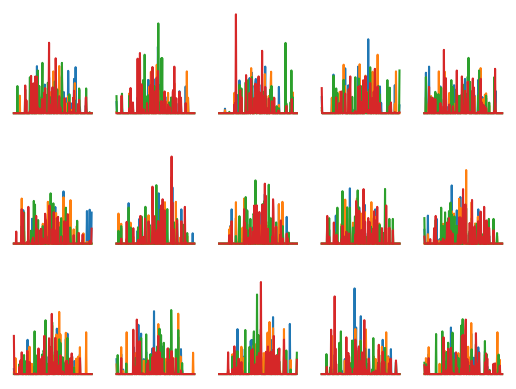

In [83]:
fig=plt.figure(dpi=100)
plot_voltage_traces(other_recs_rnn)

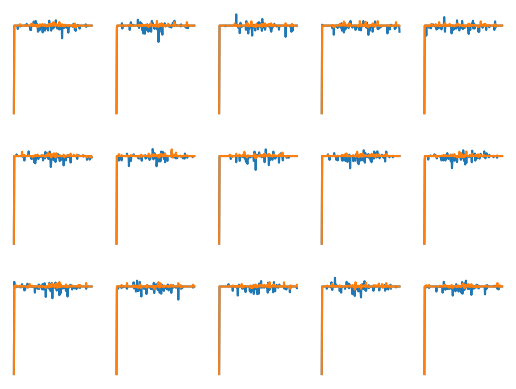

In [84]:
fig=plt.figure(dpi=100)
plot_voltage_traces(out_rec_rnn)

In [85]:
print_classification_accuracy(run_rnn) # This is relatively close to chance accuracy. We still need to train the models

Accuracy 0.488


- In the following, we will build the output layer as a population of leaky integrator neurons. The reason for this choice is that leaky integration is the natural way of how neurons receive the spiking output of their brethren.

- We use this as the output layer to be consistent with the SNN model. So all the ANN data must be converted to something that can be used for SNNs.

In [86]:
# The following lines will reinitialize the weights
torch.nn.init.normal_(w1, mean=0.0, std=weight_scale/np.sqrt(nb_inputs))
torch.nn.init.normal_(w2, mean=0.0, std=weight_scale/np.sqrt(nb_hidden))
print("init done")

init done


In [87]:
def run_rnn_with_LIF_output(inputs, timesteps=nb_steps):
    inputs = inputs.to(device)
    
    # Weights for the hidden layer for RNN is just w1 -- multiplying by inputs just gives us the output at each timestep
    h1 = torch.einsum("abc,cd->abd", (inputs, w1))
    # We could also add a bias term but let's exclude for now to make the merging more simple

    interim_rec = []

    # The difference for a pure ANN is that the hidden and the output layer usually happen at the same time
    # It's really fine that they're different here though if we just compute them sequentially

    for t in range(timesteps):

        layer_weights = h1[:,t]

        # Use a relu function similar to what's done in other models
        out = torch.relu(layer_weights)
        interim_rec.append(out)

    interim_rec = torch.stack(interim_rec,dim=1)
    # We will use the same LIF model as before, and just use the raw output as an input to start since it has a window of 1

    # Readout layer
    h2= torch.einsum("abc,cd->abd", (interim_rec, w2))
    flt = torch.zeros((batch_size,nb_outputs), device=device, dtype=dtype)
    out = torch.zeros((batch_size,nb_outputs), device=device, dtype=dtype)
    out_rec = [out]

    # Convert the h2 readout layer to a rate that can be transmitted to the output layer
    
    for t in range(nb_steps):
        new_flt = alpha*flt +h2[:,t]
        new_out = beta*out +flt

        flt = new_flt
        out = new_out

        out_rec.append(out)

    out_rec = torch.stack(out_rec,dim=1)
    other_recs = interim_rec
    return out_rec, other_recs

In [88]:
out_rec_rnn,other_recs_rnn = run_rnn_with_LIF_output(x_data)

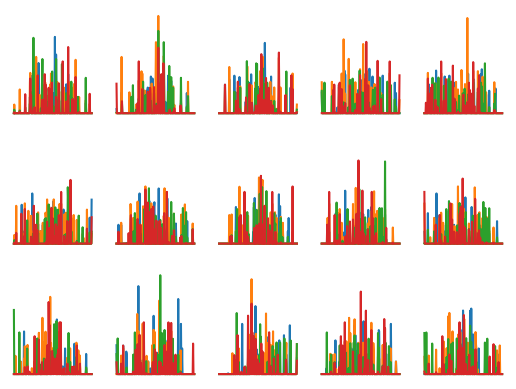

In [89]:
fig=plt.figure(dpi=100)
plot_voltage_traces(other_recs_rnn)

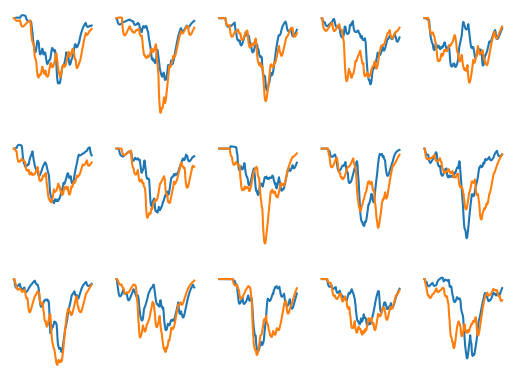

In [90]:
fig=plt.figure(dpi=100)
plot_voltage_traces(out_rec_rnn)

In [91]:
print_classification_accuracy(run_rnn_with_LIF_output) # This is relatively close to chance accuracy. We still need to train the models

Accuracy 0.438


In [92]:
v1 = torch.zeros((batch_size,nb_hidden), device=device, dtype=dtype)

##### With Recurrent Network

In [93]:
def run_rnn_with_LIF_output_rec(inputs, timesteps=nb_steps):
    inputs = inputs.to(device)

    v1 = torch.empty((nb_hidden, nb_hidden), device=device, dtype=dtype, requires_grad=True)
    torch.nn.init.normal_(v1, mean=0.0, std=weight_scale/np.sqrt(nb_hidden))

    # Weights for the hidden layer for RNN is just w1 -- multiplying by inputs just gives us the output at each timestep
    h1 = torch.einsum("abc,cd->abd", (inputs, w1))
    # We could also add a bias term but let's exclude for now to make the merging more simple

    interim_rec = []
    
    # The difference for a pure ANN is that the hidden and the output layer usually happen at the same time
    # It's really fine that they're different here though if we just compute them sequentially
    out = torch.zeros((batch_size, nb_hidden), device=device, dtype=dtype)

    for t in range(timesteps):

        layer_weights = h1[:,t] + torch.einsum("ab,bc->ac", (out, v1))

        # Use a relu function similar to what's done in other models
        out = torch.relu(layer_weights)
        interim_rec.append(out)

    interim_rec = torch.stack(interim_rec,dim=1)
    # We will use the same LIF model as before, and just use the raw output as an input to start since it has a window of 1

    # Readout layer
    h2= torch.einsum("abc,cd->abd", (interim_rec, w2))
    flt = torch.zeros((batch_size,nb_outputs), device=device, dtype=dtype)
    out = torch.zeros((batch_size,nb_outputs), device=device, dtype=dtype)
    out_rec = [out]

    # Convert the h2 readout layer to a rate that can be transmitted to the output layer
    
    for t in range(nb_steps):
        new_flt = alpha*flt +h2[:,t]
        new_out = beta*out +flt

        flt = new_flt
        out = new_out

        out_rec.append(out)

    out_rec = torch.stack(out_rec,dim=1)
    other_recs = interim_rec
    return out_rec, other_recs

In [94]:
out_rec_rnn,other_recs_rnn = run_rnn_with_LIF_output_rec(x_data)

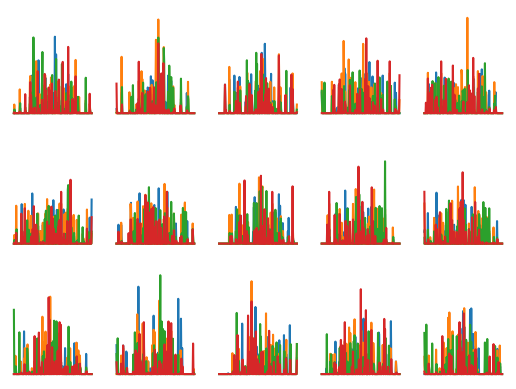

In [95]:
fig=plt.figure(dpi=100)
plot_voltage_traces(other_recs_rnn)

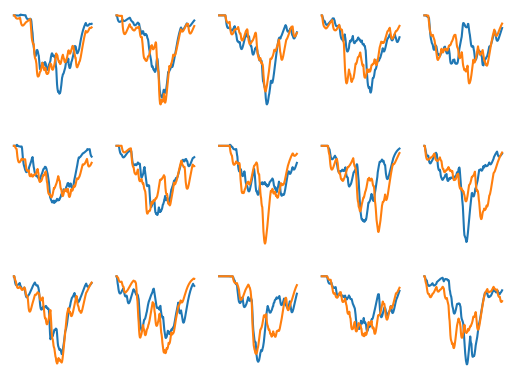

In [96]:
fig=plt.figure(dpi=100)
plot_voltage_traces(out_rec_rnn)

In [97]:
print_classification_accuracy(run_rnn_with_LIF_output_rec) # This is relatively close to chance accuracy. We still need to train the models

Accuracy 0.438


#### ANN and SNN

For this implementation, we just have 1 timestep, so we don't need to worry about converting ANN to SNN or any of the intermediary weights.

In [98]:
torch.manual_seed(42)
snn_mask = torch.randint(0, 2, (nb_hidden,), dtype=torch.float32, device=device)  # Randomly assign spiking or analog neurons
snn_mask # 1 is spiking

tensor([1., 1., 0., 0.], device='mps:0')

Options for SNN to ANN conversion include:
1. Time of first spike (this makes less sense with a window of size one)
2. Rate (this also makes less sense with a window of size one)
3. ISI (it's a difference between spikes so I think this also makes less sense)
4. Just take it and weight it (learnable) --> trying this first

In [99]:
# The following lines will reinitialize the weights
torch.nn.init.normal_(w1, mean=0.0, std=weight_scale/np.sqrt(nb_inputs))
torch.nn.init.normal_(w2, mean=0.0, std=weight_scale/np.sqrt(nb_hidden))
print("init done")

init done


There are 2 items we need to account for in the ANN and SNN implementatio
1. How ANNs take in the existing SNN data (complete)
2. How ANNs take in the data from prior timesteps (TBD, for next iteration)
3. How ANNs and SNNs combine for the final output (maybe look to the combination in the paper??)

In [100]:
def run_hybrid(inputs, timesteps=nb_steps):
    inputs = inputs.to(device)
    # Weight matrix for training, I think this can be used for both SNN and ANN but the training may have to be different
    h1 = torch.einsum("abc,cd->abd", (inputs, w1))
    # Let's just do 2 matrices to keep it clean for now
    h1_ann = h1.clone() * (1.0-snn_mask)  # ANN neurons
    h1_snn = h1.clone() * snn_mask  # SNN neurons
    syn = torch.zeros((batch_size,nb_hidden), device=device, dtype=dtype)
    mem = torch.zeros((batch_size,nb_hidden), device=device, dtype=dtype)

    mem_rec = []
    spk_rec = []
    ann_rec = []

    # Compute hidden layer activity
    for t in range(timesteps):

        # SNN neurons

        # Apply the mask to the synaptic input to ensure SNN neurons are only updated with spiking rules
        mem = mem*snn_mask
        syn = syn*snn_mask

        mthr = mem-1.0
        out_snn = spike_fn(mthr)
        rst = out_snn.detach() # We do not want to backprop through the reset

        new_syn = alpha*syn +h1_snn[:,t]
        new_mem = (beta*mem +syn)*(1.0-rst)

        mem_rec.append(mem)
        spk_rec.append(out_snn)

        # ANN neurons - don't interact with the synaptic input at all to start
        out_ann = torch.relu(h1_ann[:,t])
        ann_rec.append(out_ann)
        
        mem = new_mem
        syn = new_syn

    mem_rec = torch.stack(mem_rec,dim=1)
    spk_rec = torch.stack(spk_rec,dim=1)
    ann_rec = torch.stack(ann_rec,dim=1)

    h2_snn = torch.einsum("abc,cd->abd", (spk_rec, w2))
    h2_ann= torch.einsum("abc,cd->abd", (ann_rec, w2))

    # We can add the two together to get the final output since the two do not interact at all
    h2 = h2_snn + h2_ann

    flt = torch.zeros((batch_size,nb_outputs), device=device, dtype=dtype)
    out = torch.zeros((batch_size,nb_outputs), device=device, dtype=dtype)
    out_rec = [out]
    for t in range(timesteps):
        new_flt = alpha*flt +h2[:,t]
        new_out = beta*out +flt

        flt = new_flt
        out = new_out

        out_rec.append(out)

    out_rec = torch.stack(out_rec,dim=1)
    other_recs = [mem_rec, spk_rec, ann_rec]
    return out_rec, other_recs

In [101]:
out_rec_h,other_recs_h = run_hybrid(x_data)

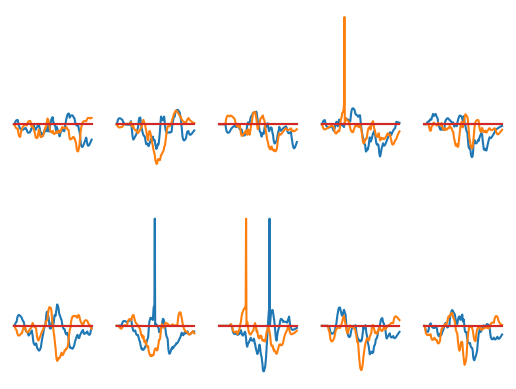

In [102]:
fig=plt.figure(dpi=100)
plot_voltage_traces(other_recs_h[0],other_recs_h[1],dim=(2,5))

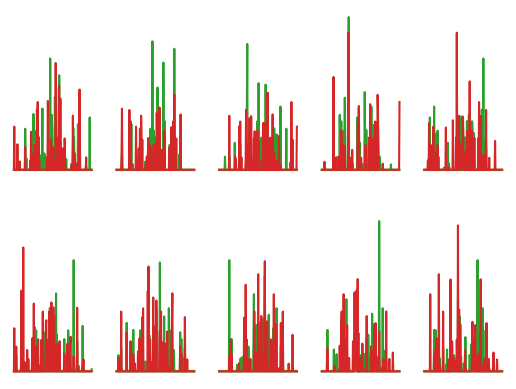

In [103]:
fig=plt.figure(dpi=100)
plot_voltage_traces(other_recs_h[2],dim=(2,5))

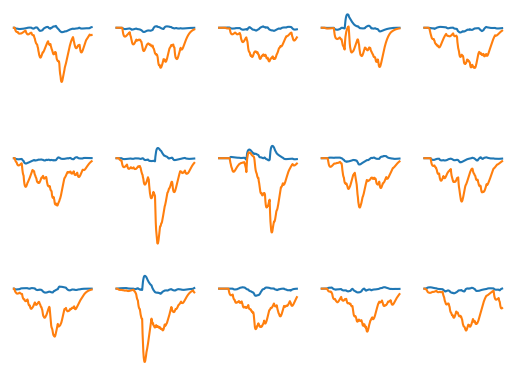

In [104]:
fig=plt.figure(dpi=100)
plot_voltage_traces(out_rec_h)

In [105]:
print_classification_accuracy(run_hybrid) # This is relatively close to chance accuracy. We still need to train the models

Accuracy 0.449


##### With Recurrent Network

In [106]:
# So weights are retained
v1 = torch.empty((nb_hidden, nb_hidden), device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(v1, mean=0.0, std=weight_scale/np.sqrt(nb_hidden))

tensor([[ 0.1323, -0.0432, -0.1354,  0.0157],
        [ 0.0455, -0.3469, -0.4124, -0.3504],
        [-0.4141,  0.3460, -0.1953,  0.1828],
        [ 0.2497, -0.2737, -0.4129, -0.3633]], device='mps:0',
       requires_grad=True)

In [107]:
def run_hybrid_ann_rec(inputs, timesteps=nb_steps):
    inputs = inputs.to(device)
    # Weight matrix for training, I think this can be used for both SNN and ANN but the training may have to be different
    h1 = torch.einsum("abc,cd->abd", (inputs, w1))
    # Let's just do 2 matrices to keep it clean for now
    h1_ann = h1.clone() * (1.0-snn_mask)  # ANN neurons
    h1_snn = h1.clone() * snn_mask  # SNN neurons
    syn = torch.zeros((batch_size,nb_hidden), device=device, dtype=dtype)
    mem = torch.zeros((batch_size,nb_hidden), device=device, dtype=dtype)

    mem_rec = []
    spk_rec = []
    ann_rec = []

    out_ann = torch.zeros((batch_size, nb_hidden), device=device, dtype=dtype)
    
    # Compute hidden layer activity
    for t in range(timesteps):

        # SNN neurons

        # Apply the mask to the synaptic input to ensure SNN neurons are only updated with spiking rules
        mem = mem*snn_mask
        syn = syn*snn_mask

        mthr = mem-1.0
        out_snn = spike_fn(mthr)
        rst = out_snn.detach() # We do not want to backprop through the reset

        new_syn = alpha*syn +h1_snn[:,t]
        new_mem = (beta*mem +syn)*(1.0-rst)

        mem_rec.append(mem)
        spk_rec.append(out_snn)

        # ANN neurons - don't interact with the synaptic input at all to start
        out_ann = torch.relu(h1_ann[:,t]) + torch.einsum("ab,bc->ac", (out_ann, v1))
        ann_rec.append(out_ann)
        
        mem = new_mem
        syn = new_syn

    mem_rec = torch.stack(mem_rec,dim=1)
    spk_rec = torch.stack(spk_rec,dim=1)
    ann_rec = torch.stack(ann_rec,dim=1)

    h2_snn = torch.einsum("abc,cd->abd", (spk_rec, w2))
    h2_ann= torch.einsum("abc,cd->abd", (ann_rec, w2))

    # We can add the two together to get the final output since the two do not interact at all
    h2 = h2_snn + h2_ann

    flt = torch.zeros((batch_size,nb_outputs), device=device, dtype=dtype)
    out = torch.zeros((batch_size,nb_outputs), device=device, dtype=dtype)
    out_rec = [out]
    for t in range(timesteps):
        new_flt = alpha*flt +h2[:,t]
        new_out = beta*out +flt

        flt = new_flt
        out = new_out

        out_rec.append(out)

    out_rec = torch.stack(out_rec,dim=1)
    other_recs = [mem_rec, spk_rec, ann_rec]
    return out_rec, other_recs

In [108]:
out_rec_h,other_recs_h = run_hybrid_ann_rec(x_data)

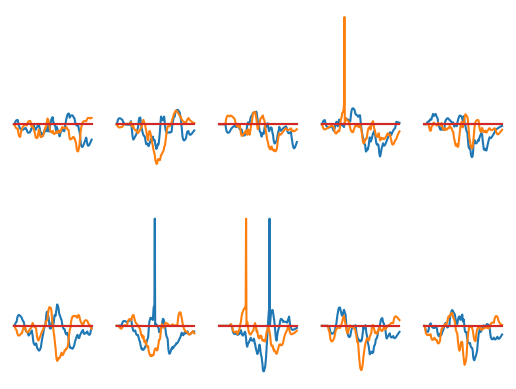

In [109]:
fig=plt.figure(dpi=100)
plot_voltage_traces(other_recs_h[0],other_recs_h[1],dim=(2,5))

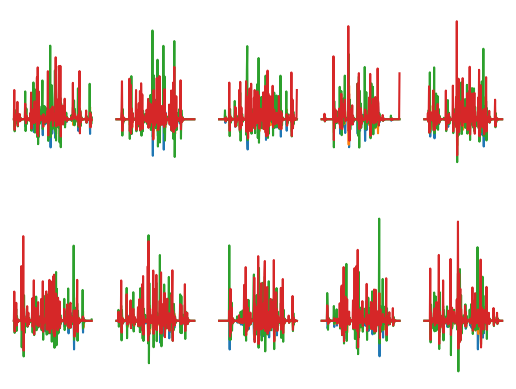

In [110]:
fig=plt.figure(dpi=100)
plot_voltage_traces(other_recs_h[2],dim=(2,5))

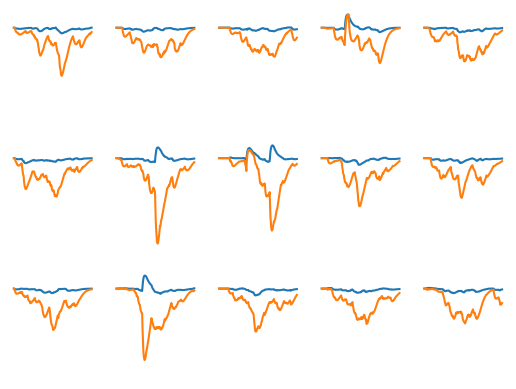

In [111]:
fig=plt.figure(dpi=100)
plot_voltage_traces(out_rec_h)

In [112]:
print_classification_accuracy(run_hybrid_ann_rec) # This is relatively close to chance accuracy. We still need to train the models

Accuracy 0.449


### With Training (Surrogate Gradient)

In [113]:
class SurrGradSpike(torch.autograd.Function):
    """
    Here we implement our spiking nonlinearity which also implements 
    the surrogate gradient. By subclassing torch.autograd.Function, 
    we will be able to use all of PyTorch's autograd functionality.
    Here we use the normalized negative part of a fast sigmoid 
    as this was done in Zenke & Ganguli (2018).
    """
    
    scale = 100.0 # controls steepness of surrogate gradient

    @staticmethod
    def forward(ctx, input):
        """
        In the forward pass we compute a step function of the input Tensor
        and return it. ctx is a context object that we use to stash information which 
        we need to later backpropagate our error signals. To achieve this we use the 
        ctx.save_for_backward method.
        """
        ctx.save_for_backward(input)
        out = torch.zeros_like(input)
        out[input > 0] = 1.0
        return out

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor we need to compute the 
        surrogate gradient of the loss with respect to the input. 
        Here we use the normalized negative part of a fast sigmoid 
        as this was done in Zenke & Ganguli (2018).
        """
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad = grad_input/(SurrGradSpike.scale*torch.abs(input)+1.0)**2
        return grad
    
# here we overwrite our naive spike function by the "SurrGradSpike" nonlinearity which implements a surrogate gradient
spike_fn = SurrGradSpike.apply

#### SNN Only

In [114]:
# The following lines will reinitialize the weights
torch.nn.init.normal_(w1, mean=0.0, std=weight_scale/np.sqrt(nb_inputs))
torch.nn.init.normal_(w2, mean=0.0, std=weight_scale/np.sqrt(nb_hidden))
print("init done")

params = [w1,w2]
optimizer = torch.optim.Adam(params, lr=2e-3, betas=(0.9,0.999))

log_softmax_fn = nn.LogSoftmax(dim=1)
loss_fn = nn.NLLLoss()

loss_hist = []
for e in range(100):
    output,_ = run_snn(x_data)
    m,_=torch.max(output,1)
    log_p_y = log_softmax_fn(m)
    loss_val = loss_fn(log_p_y, y_data)

    optimizer.zero_grad()
    loss_val.backward()
    optimizer.step()
    loss_hist.append(loss_val.item())

init done


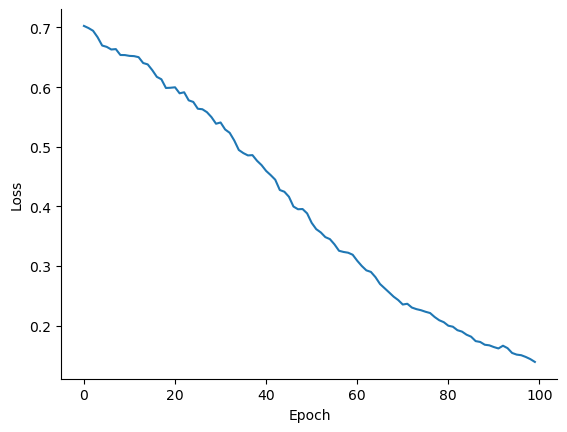

In [115]:
plt.plot(loss_hist)
plt.xlabel("Epoch")
plt.ylabel("Loss")
sns.despine()

In [116]:
def compute_classification_accuracy(x_data, y_data, model=run_snn):
    """ 
    Computes classification accuracy and confusion matrix on supplied data in batches.
    
    Returns:
        accuracy: Overall classification accuracy.
        conf_matrix: Confusion matrix of shape (num_classes, num_classes).
    """
    all_preds = []
    all_labels = []

    output,_ = model(x_data)
    m,_=torch.max(output,1)

    # Compute training accuracy
    _,am=torch.max(m,1)
    acc = np.mean((y_data==am).detach().cpu().numpy())
    all_preds.extend(am.cpu().numpy())
    all_labels.extend(y_data.cpu().numpy())

    # Compute overall accuracy

    # Compute confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)

    return acc, conf_matrix
    
def plot_confusion_matrix(conf_matrix, class_names, title):
    """ Plots the confusion matrix. """
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"{title} Confusion Matrix - Random Manifolds")
    plt.show()

In [117]:
output,other_recordings = run_snn(x_data)
mem_rec, spk_rec = other_recordings

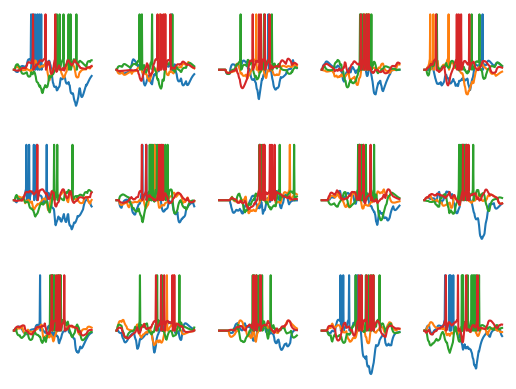

In [118]:
fig=plt.figure(dpi=100)
plot_voltage_traces(mem_rec, spk_rec)

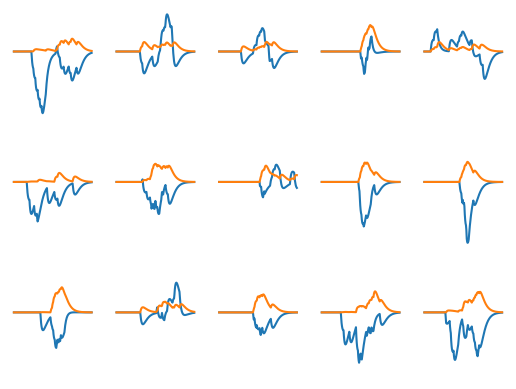

In [119]:
fig=plt.figure(dpi=100)
plot_voltage_traces(output)

Train Accuracy: 98.44%


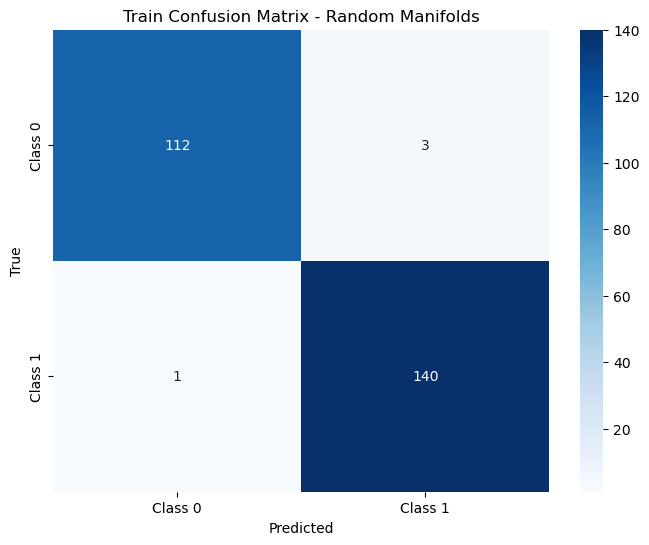

In [120]:
train_accuracy, train_conf_matrix = compute_classification_accuracy(x_data, y_data)

# Print results
print(f"Train Accuracy: {train_accuracy * 100:.2f}%")
class_names = [f"Class {i}" for i in range(nb_outputs)]

# Plot the confusion matrix
plot_confusion_matrix(train_conf_matrix, class_names, "Train")

Test Accuracy: 91.02%


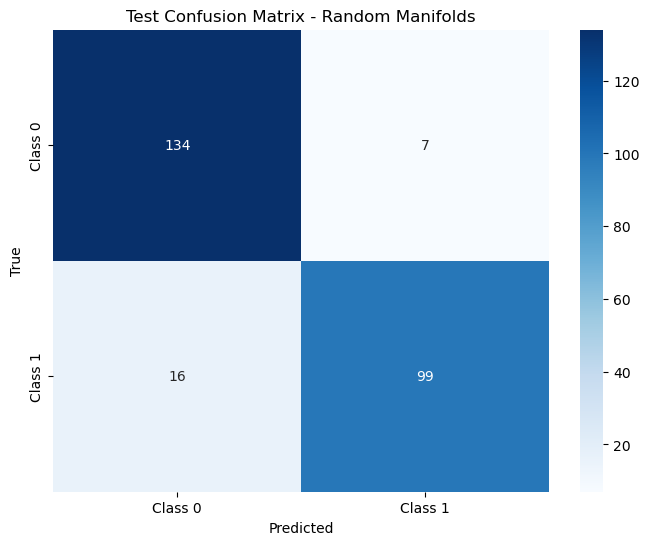

In [121]:
test_accuracy, test_conf_matrix = compute_classification_accuracy(x_test, y_test)

# Print results
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
class_names = [f"Class {i}" for i in range(nb_outputs)]

# Plot the confusion matrix
plot_confusion_matrix(test_conf_matrix, class_names, "Test")

#### ANN Only

In [122]:
# The following lines will reinitialize the weights
torch.nn.init.normal_(w1, mean=0.0, std=weight_scale/np.sqrt(nb_inputs))
torch.nn.init.normal_(w2, mean=0.0, std=weight_scale/np.sqrt(nb_hidden))
torch.nn.init.normal_(v1, mean=0.0, std=weight_scale/np.sqrt(nb_inputs))

print("init done")

params = [w1,w2]
optimizer = torch.optim.Adam(params, lr=2e-3, betas=(0.9,0.999))

log_softmax_fn = nn.LogSoftmax(dim=1)
loss_fn = nn.NLLLoss()

loss_hist = []
for e in range(100):
    output,_ = run_rnn_with_LIF_output_rec(x_data)
    m,_=torch.max(output,1)
    log_p_y = log_softmax_fn(m)
    loss_val = loss_fn(log_p_y, y_data)

    optimizer.zero_grad()
    loss_val.backward()
    optimizer.step()
    loss_hist.append(loss_val.item())

init done


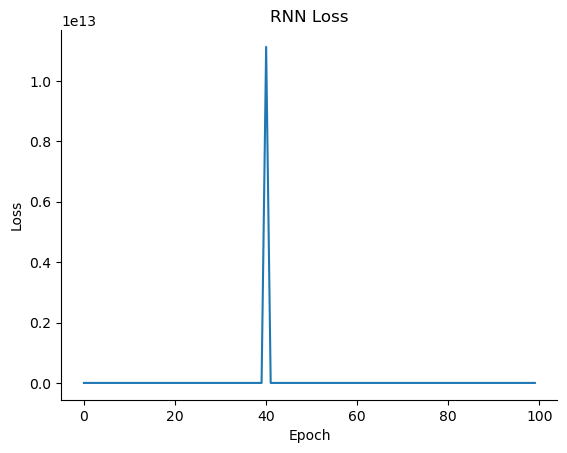

In [123]:
plt.plot(loss_hist)
plt.title("RNN Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
sns.despine()

In [124]:
output,other_recordings = run_rnn_with_LIF_output(x_data)


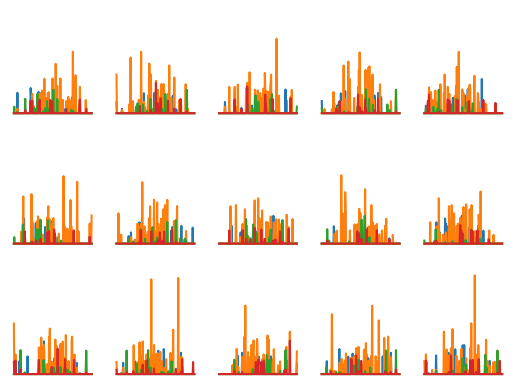

In [125]:
fig=plt.figure(dpi=100)
plot_voltage_traces(other_recordings)

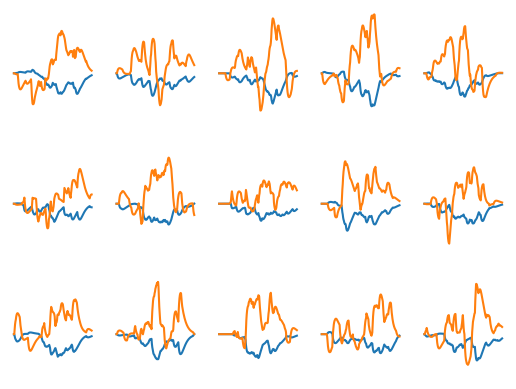

In [126]:
fig=plt.figure(dpi=100)
plot_voltage_traces(output)

Train Accuracy: 55.08%


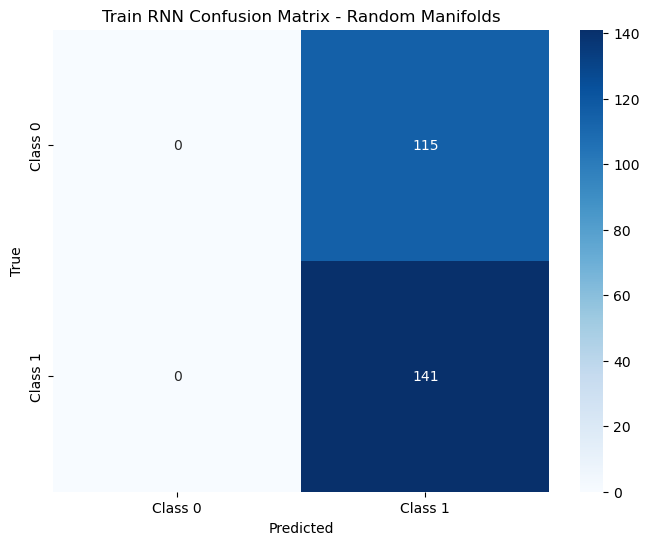

In [127]:
train_accuracy, train_conf_matrix = compute_classification_accuracy(x_data, y_data, model=run_rnn_with_LIF_output_rec)

# Print results
print(f"Train Accuracy: {train_accuracy * 100:.2f}%")
class_names = [f"Class {i}" for i in range(nb_outputs)]

# Plot the confusion matrix
plot_confusion_matrix(train_conf_matrix, class_names, "Train RNN")

Test Accuracy: 44.92%


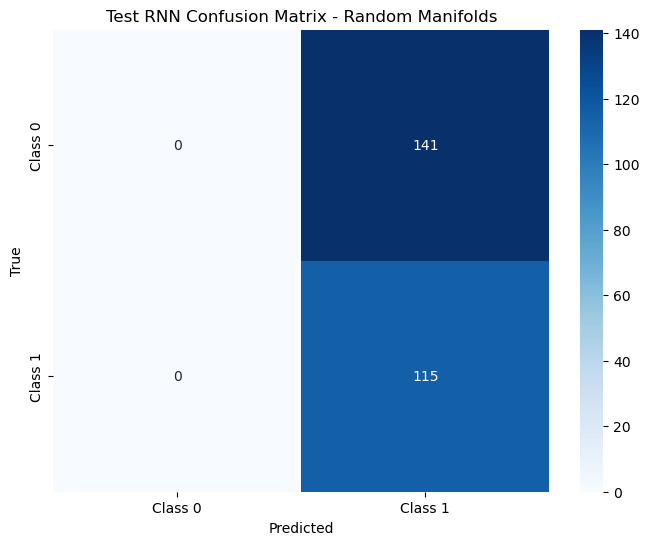

In [128]:
test_accuracy, test_conf_matrix = compute_classification_accuracy(x_test, y_test, model=run_rnn_with_LIF_output_rec)

# Print results
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
class_names = [f"Class {i}" for i in range(nb_outputs)]

# Plot the confusion matrix
plot_confusion_matrix(test_conf_matrix, class_names, "Test RNN")

#### ANN and SNN Hybrid

In [ ]:
# The following lines will reinitialize the weights
torch.nn.init.normal_(w1, mean=0.0, std=weight_scale/np.sqrt(nb_inputs))
torch.nn.init.normal_(w2, mean=0.0, std=weight_scale/np.sqrt(nb_hidden))
torch.nn.init.normal_(v1, mean=0.0, std=weight_scale/np.sqrt(nb_inputs))

print("init done")

params = [w1,w2]
optimizer = torch.optim.Adam(params, lr=2e-3, betas=(0.9,0.999))

log_softmax_fn = nn.LogSoftmax(dim=1)
loss_fn = nn.NLLLoss()

loss_hist = []
for e in range(100):
    output,_ = run_hybrid_ann_rec(x_data)
    m,_=torch.max(output,1)
    log_p_y = log_softmax_fn(m)
    loss_val = loss_fn(log_p_y, y_data)

    optimizer.zero_grad()
    loss_val.backward()
    optimizer.step()
    loss_hist.append(loss_val.item())

init done


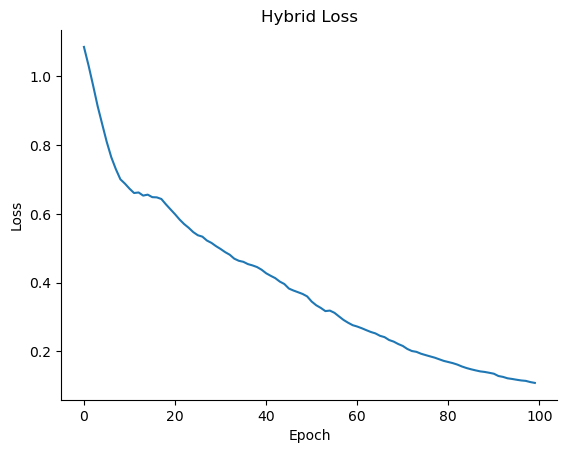

In [ ]:
plt.plot(loss_hist)
plt.title("Hybrid Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
sns.despine()

In [ ]:
output,other_recs_h = run_hybrid_ann_rec(x_data)

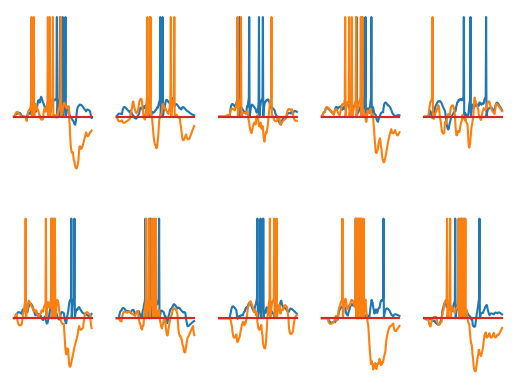

In [ ]:
fig=plt.figure(dpi=100)
plot_voltage_traces(other_recs_h[0],other_recs_h[1],dim=(2,5))

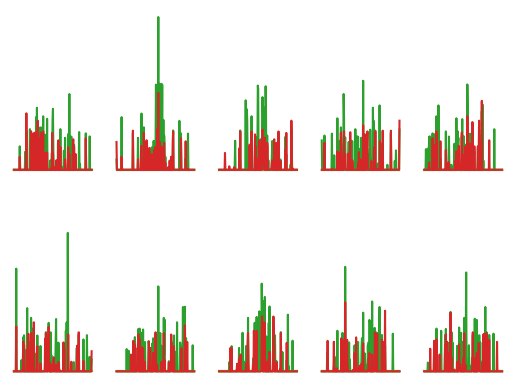

In [ ]:
fig=plt.figure(dpi=100)
plot_voltage_traces(other_recs_h[2],dim=(2,5))

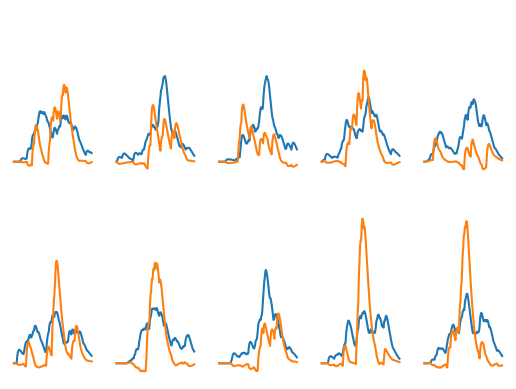

In [ ]:
fig=plt.figure(dpi=100)
plot_voltage_traces(output,dim=(2,5))

Train Accuracy: 99.22%


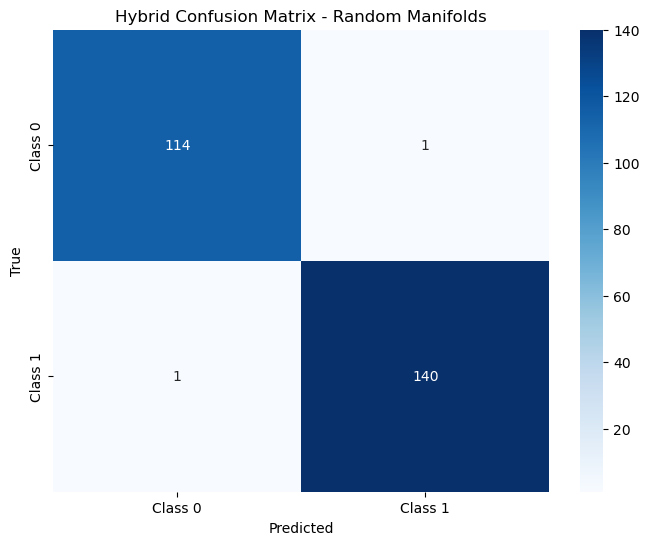

In [ ]:
train_accuracy, train_conf_matrix = compute_classification_accuracy(x_data, y_data, model=run_hybrid_ann_rec)

# Print results
print(f"Train Accuracy: {train_accuracy * 100:.2f}%")
class_names = [f"Class {i}" for i in range(nb_outputs)]

# Plot the confusion matrix
plot_confusion_matrix(train_conf_matrix, class_names, "Hybrid")

Test Accuracy: 93.75%


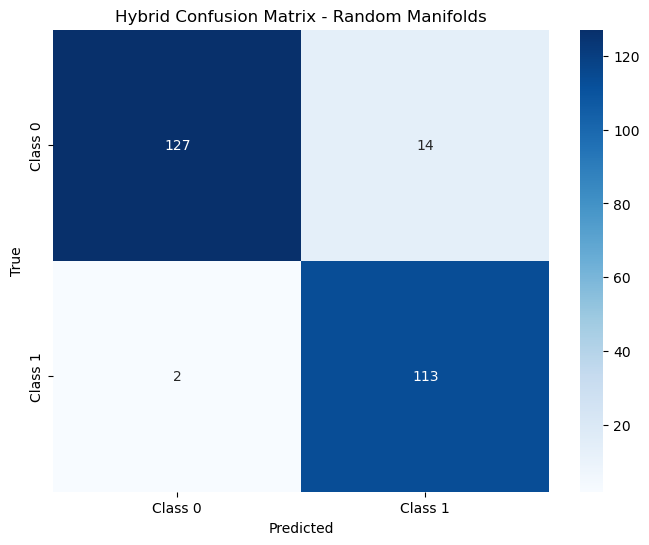

In [ ]:
test_accuracy, test_conf_matrix = compute_classification_accuracy(x_test, y_test, model=run_hybrid_ann_rec)

# Print results
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
class_names = [f"Class {i}" for i in range(nb_outputs)]

# Plot the confusion matrix
plot_confusion_matrix(test_conf_matrix, class_names, "Hybrid")